## Sentiment Analysis Algorithms

## Set Up

In [ ]:
!pip install vaderSentiment
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
import os
from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import csv

pd.options.mode.chained_assignment = None
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 125 kB 5.2 MB/s 
Mounted at /content/drive


In [ ]:
os.chdir("drive/My Drive") # after you run this once you will get an error if you run again. You can ignore

### Set Parameters

In [ ]:
repull_data = False
display_images = True
perform_vader = False
perform_specific_sentiments = False
perform_text_blob = False

# if false only evaluates headlines for 'specific emotions' analysis
evaluate_article_content = True

In [ ]:
 import sqlite3 as sql
 
 cnx_2018 = sql.connect('USML_Project/Data/2018_articles.db')

## Extract Data - Process Text

In [ ]:
import datetime as dt
from datetime import datetime
nltk.download('stopwords')

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'https', 'said', 'us', 
                   'would', 'like','says', 'could', 'two', 'told', 'going', 'one'])

if repull_data:

  fox_2018 = pd.read_sql_query("SELECT * FROM articles WHERE source LIKE '%Fox%'", cnx_2018)
  nbc_2018 = pd.read_sql_query("SELECT * FROM articles WHERE source LIKE '%NBC%'", cnx_2018)
  cnn_2018 = pd.read_sql_query("SELECT * FROM articles WHERE source LIKE '%CNN%'", cnx_2018)

  ### update the dataframe names if changing
  all_dfs = [nbc_2018, fox_2018, cnn_2018]
  ###

  for df in all_dfs:
    df['date']= pd.to_datetime(df['date'])
    df["edited_name"] = df["name"].str.lower().str.replace('[^\w\s]','')
    df["edited_content"] = df["content"].str.lower().str.replace('[^\w\s]','')
    df['edited_name'] = df['edited_name'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])).str.split()
    df['edited_content'] = df['edited_content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])).str.split()
    df = df.drop_duplicates(["content"])

else:
  fox_2018 = pd.read_excel("USML_Project/Data/jake/fox_full_sample.xlsx")
  cnn_2018 = pd.read_excel("USML_Project/Data/jake/cnn_full_sample.xlsx")
  nbc_2018 = pd.read_excel("USML_Project/Data/jake/nbc_full_sample.xlsx")

  all_dfs = [nbc_2018, fox_2018, cnn_2018]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Evaluate Sentiments VADER

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# function to print sentiments of the sentence.
threshold = 0.05

def sentiment_scores(df, text):

    sid_obj = SentimentIntensityAnalyzer()
    # polarity_scores method of SentimentIntensityAnalyzer. oject gives a 
    # sentiment dictionary. which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(text)

    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= threshold:
      return 'positive'
    elif sentiment_dict['compound'] <= -threshold:
      return 'negative'
    else:
      return 'neutral'


if perform_vader:
  
  for df in all_dfs:
    df['headline_vader'] = np.empty((len(df), 0)).tolist()
    df['article_vader'] = np.empty((len(df), 0)).tolist()

    for index, row in df.iterrows():
      head_line = row['name']
      article = row['content']

      df['headline_vader'].iloc[index] = sentiment_scores(df, head_line)
      df['article_vader'].iloc[index] = sentiment_scores(df, article)

## Visualize VADER

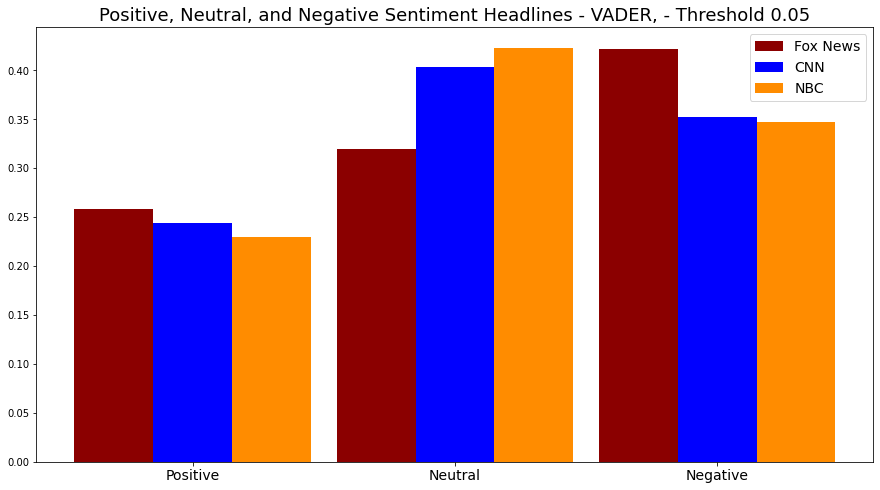

In [ ]:
from collections import Counter

# sentiments = ['positive', 'neutral', 'negative']

def get_sentiment_counts(df_column):

  return [df_column.value_counts().positive, 
              df_column.value_counts().neutral, 
              df_column.value_counts().negative]

fox_headline_counts = get_sentiment_counts(fox_2018.headline_vader)
nbc_headline_counts = get_sentiment_counts(nbc_2018.headline_vader)
cnn_headline_counts = get_sentiment_counts(cnn_2018.headline_vader)

fox_article_counts = get_sentiment_counts(fox_2018.article_vader)
nbc_article_counts = get_sentiment_counts(nbc_2018.article_vader)
cnn_article_counts = get_sentiment_counts(cnn_2018.article_vader)


# Figure out how to plot with a for loop

if display_images:

  width = 0.3
  N = 3
  ind = np.arange(N)

  plt.figure(figsize = (15,8))
  plt.bar(ind, [counts / len(fox_2018) for counts in fox_headline_counts], width = .3, label = "Fox News", color = 'darkred')
  plt.bar(ind + width, [counts / len(cnn_2018) for counts in cnn_headline_counts], width = .3, label = "CNN", color = 'blue')
  plt.bar(ind + width + width, [counts / len(nbc_2018) for counts in nbc_headline_counts], width = .3, label = 'NBC', color = 'darkorange')
  plt.xticks(ind + 2*width / 2, ('Positive', 'Neutral', 'Negative'), fontsize = 14)
  plt.title("Positive, Neutral, and Negative Sentiment Headlines - VADER, - Threshold 0.05", fontsize = 18)
  plt.legend(loc='best', fontsize = 14)
  plt.show()

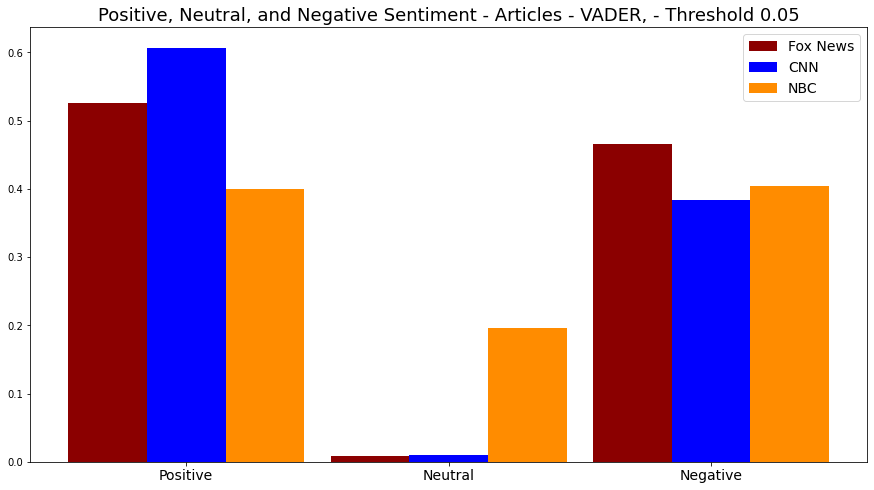

In [ ]:
if display_images:

  width = 0.3
  N = 3
  ind = np.arange(N)

  plt.figure(figsize = (15,8))
  plt.bar(ind, [counts / len(fox_2018) for counts in fox_article_counts], width = .3, label = "Fox News", color = 'darkred')
  plt.bar(ind + width, [counts / len(cnn_2018) for counts in cnn_article_counts], width = .3, label = "CNN", color = 'blue')
  plt.bar(ind + width + width, [counts / len(nbc_2018) for counts in nbc_article_counts], width = .3, label = 'NBC', color = 'darkorange')
  plt.xticks(ind + 2*width / 2, ('Positive', 'Neutral', 'Negative'), fontsize = 14)
  plt.title("Positive, Neutral, and Negative Sentiment - Articles - VADER, - Threshold 0.05", fontsize = 18)
  plt.legend(loc='best', fontsize = 14)
  plt.show()

## Specific Emotion Analysis

### Create Word-Emotion Association Columns

In [ ]:
# https://github.com/attreyabhatt/Sentiment-Analysis

emotion_list = []
word_list = []

with open('USML_Project/Data/emotions.txt', 'r') as file:
  for line in file:
    cleaned_line = line.strip().replace("'", "").replace(",", "")
    word, emotion = cleaned_line.split(": ")
    word_list.append(word)
    emotion_list.append(emotion)

In [ ]:
## Emotions of Headlines

## Create the list of emotions present column

if repull_data:

  # indicate the dataframe names
  all_dfs = [nbc_2018, fox_2018, cnn_2018]

  for df in all_dfs:  # iterate dataframes
    df['headline_emotions'] = np.empty((len(df), 0)).tolist()

    for article in range(len(df)):  # iterate rows of dataframe
      for i in range(len(word_list)):  # iterate over words associated with emotions
        if word_list[i] in df.iloc[article]['edited_name']:
          df.iloc[article]['headline_emotions'] = df.iloc[article]['headline_emotions'].append(emotion_list[i])

In [ ]:
## Emotions of article content

## Create the list of emotions present column

if repull_data:

  # indicate the dataframe names
  all_dfs = [nbc_2018, fox_2018, cnn_2018]

  for df in all_dfs:  # iterate dataframes
    df['article_emotions'] = np.empty((len(df), 0)).tolist()

    for article in range(len(df)):  # iterate rows of dataframe
      for i in range(len(word_list)):  # iterate over words associated with emotions
        if word_list[i] in df.iloc[article]['edited_content']:
          df.iloc[article]['article_emotions'] = df.iloc[article]['article_emotions'].append(emotion_list[i])

### NBC Emotion Counter

In [ ]:
import ast

evaluate_article_content = True

all_words = []

for article in range(len(nbc_2018)):
  if evaluate_article_content:
    if repull_data:
      all_words = all_words + nbc_2018.iloc[article]['article_emotions']
    else:
      all_words = all_words + ast.literal_eval(nbc_2018.iloc[article]['article_emotions'])
  else:
    if repull_data:
      all_words = all_words + nbc_2018.iloc[article]['headline_emotions']
    else:
       all_words = all_words + ast.literal_eval(nbc_2018.iloc[article]['headline_emotions'])
    
  

# which words don't appear in the headlines, to subtract from counts later
missing_words = list(set(emotion_list) - set(all_words))

# # adds 1 of every word in emotions list to account for missing
all_words = all_words + missing_words

w_nbc = Counter(all_words)

nbc_headline_dict = dict(w_nbc)

# subtract added value to revert to real count
for key, val in nbc_headline_dict.items():
  if key in missing_words:
    nbc_headline_dict[key] = nbc_headline_dict[key] - 1 

### Fox Emotion Counter

In [ ]:
all_words = []

for article in range(len(fox_2018)):
  if evaluate_article_content:
    if repull_data:
      all_words = all_words + fox_2018.iloc[article]['article_emotions']
    else:
      all_words = all_words + ast.literal_eval(fox_2018.iloc[article]['article_emotions'])
  else:
    if repull_data:
      all_words = all_words + fox_2018.iloc[article]['headline_emotions']
    else:
      all_words = all_words + ast.literal_eval(fox_2018.iloc[article]['headline_emotions'])
    
    
# which words don't appear in the headlines, to subtract from counts later
missing_words = list(set(emotion_list) - set(all_words))

# # adds 1 of every word in emotions list to account for missing
all_words = all_words + missing_words

w_fox = Counter(all_words)
fox_headline_dict = dict(w_fox)

# subtract added value to revert to real count
for key, val in fox_headline_dict.items():
  if key in missing_words:
    fox_headline_dict[key] = fox_headline_dict[key] -1 

### CNN Emotion Counter

In [ ]:
all_words = []

for article in range(len(cnn_2018)):
  if evaluate_article_content:
    if repull_data:
      all_words = all_words + cnn_2018.iloc[article]['article_emotions']
    else:
      all_words = all_words + ast.literal_eval(cnn_2018.iloc[article]['article_emotions'])
  else:
    if repull_data:
      all_words = all_words + cnn_2018.iloc[article]['headline_emotions']
    else:
      all_words = all_words + ast.literal_eval(cnn_2018.iloc[article]['headline_emotions'])
    
# which words don't appear in the headlines, to subtract from counts later
missing_words = list(set(emotion_list) - set(all_words))

# # adds 1 of every word in emotions list to account for missing
all_words = all_words + missing_words

w_cnn = Counter(all_words)
cnn_headline_dict = dict(w_cnn)

# subtract added value to revert to real count
for key, val in cnn_headline_dict.items():
  if key in missing_words:
    cnn_headline_dict[key] = cnn_headline_dict[key] -1 

In [ ]:
top_cnn = sorted(cnn_headline_dict, key=cnn_headline_dict.get, reverse=True)[:5]
top_fox = sorted(fox_headline_dict, key=fox_headline_dict.get, reverse=True)[:5]
top_nbc = sorted(nbc_headline_dict, key=nbc_headline_dict.get, reverse=True)[:5]

# The top emotions that occur in any one of the news sources
ALL_TOPS = set(top_cnn + top_fox + top_nbc)

top_cnn = {}

for key, val in cnn_headline_dict.items():
  if key in ALL_TOPS:
    top_cnn[key] = val

top_nbc = {}

for key, val in nbc_headline_dict.items():
  if key in ALL_TOPS:
    top_nbc[key] = val

top_fox = {}

for key, val in fox_headline_dict.items():
  if key in ALL_TOPS:
    top_fox[key] = val


# Sorts the dictionaries by alphabetical order and converts to lists
top_cnn = list(sum(sorted(top_cnn.items(), key = lambda x:x[0]), ()))
top_nbc = list(sum(sorted(top_nbc.items(), key = lambda x:x[0]), ()))
top_fox = list(sum(sorted(top_fox.items(), key = lambda x:x[0]), ()))

## Visualize Most Common Specific Emotions

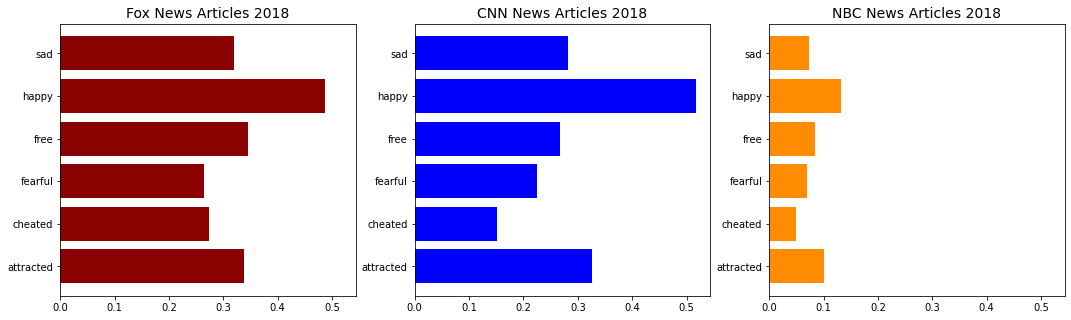

In [ ]:
if display_images:

  fig, ax = plt.subplots(1,3, figsize=(18, 5), sharey=False, sharex=True)

  from matplotlib.pyplot import figure

  ax[0].barh(top_fox[0::2], [count /len(fox_2018) for count in top_fox[1::2]], color = 'darkred')
  ax[0].set_title("Fox News Articles 2018", fontsize = 14)

  ax[1].barh(top_cnn[0::2], [count /len(cnn_2018) for count in top_cnn[1::2]], color = 'blue')
  ax[1].set_title("CNN News Articles 2018", fontsize = 14)

  ax[2].barh(top_nbc[0::2], [count /len(nbc_2018) for count in top_nbc[1::2]], color = 'darkorange')
  ax[2].set_title("NBC News Articles 2018", fontsize = 14)

  plt.show()

In [ ]:
print("Fox average article length in words: ", round(fox_2018['content'].apply(len).mean()))
print("CNN average article length in words: ", round(cnn_2018['content'].apply(len).mean()))
print("NBC average article length in words: ", round(nbc_2018['content'].apply(len).mean()))

Fox average article length in words:  4067
CNN average article length in words:  3894
NBC average article length in words:  1017


## TextBlob

Polarity is a float value within the range [-1.0 to 1.0] where 0 indicates neutral, +1 indicates a very positive sentiment and -1 represents a very negative sentiment.

Subjectivity is a float value within the range [0.0 to 1.0] where 0.0 is very objective and 1.0 is very subjective. Subjective sentence expresses some personal feelings, views, beliefs, opinions, allegations, desires, beliefs, suspicions, and speculations where as Objective sentences are factual.

In [ ]:
from textblob import TextBlob
from nltk.probability import FreqDist
nltk.download('brown')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def text_blob_scores(text):

    data = TextBlob(text)
    return data.sentiment[0], data.sentiment[1]


if perform_text_blob and repull_data:
  
  for df in all_dfs:
    df['headline_blob_polarity'] = np.empty((len(df), 0)).tolist()
    df['headline_blob_subjectivity'] = np.empty((len(df), 0)).tolist()

    df['article_blob_polarity'] = np.empty((len(df), 0)).tolist()
    df['article_blob_subjectivity'] = np.empty((len(df), 0)).tolist()


    for index, row in df.iterrows():
      head_line = row['name']
      article = row['content']

      polarity, subjectivity = text_blob_scores(head_line)
      df['headline_blob_polarity'].iloc[index] = polarity
      df['headline_blob_subjectivity'].iloc[index] = subjectivity

      polarity, subjectivity = text_blob_scores(article)
      df['article_blob_polarity'].iloc[index] = polarity
      df['article_blob_subjectivity'].iloc[index] = subjectivity

In [ ]:
# Classify the continuous scores

if perform_text_blob and repull_data:

  for df in all_dfs:

    df['headline_blob_polarity_class'] = np.empty((len(df), 0)).tolist()
    df['article_blob_polarity_class'] = np.empty((len(df), 0)).tolist()

    df.loc[df['headline_blob_polarity'] < 0, 'headline_blob_polarity_class'] = 'negative'
    df.loc[df['headline_blob_polarity'] == 0, 'headline_blob_polarity_class'] = 'neutral'
    df.loc[df['headline_blob_polarity'] > 0, 'headline_blob_polarity_class'] = 'positive'

    df.loc[df['article_blob_polarity'] < 0, 'article_blob_polarity_class'] = 'negative'
    df.loc[df['article_blob_polarity'] == 0, 'article_blob_polarity_class'] = 'neutral'
    df.loc[df['article_blob_polarity'] > 0, 'article_blob_polarity_class'] = 'positive'

## Visualize TextBlob

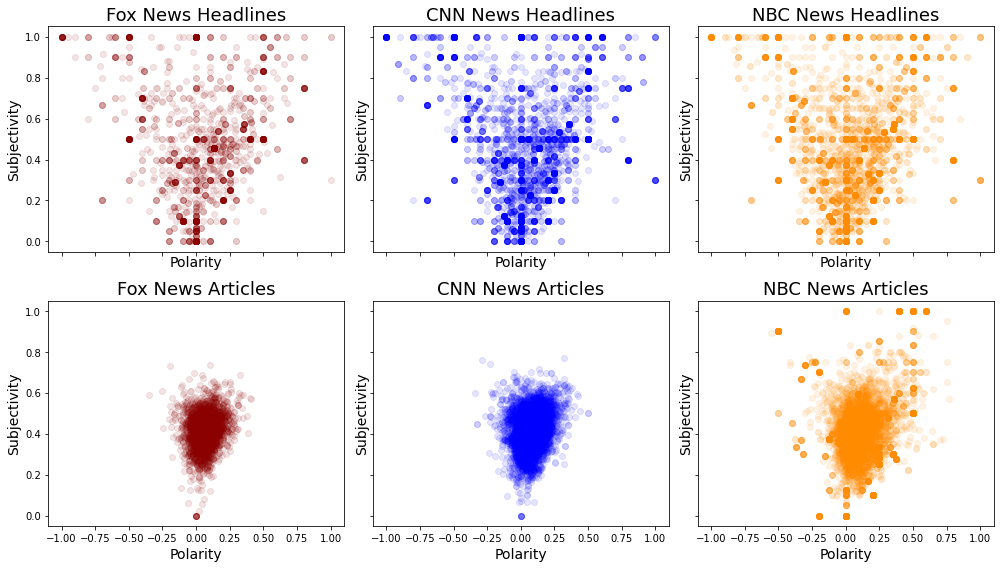

In [ ]:
if display_images:
  
  fig, ax = plt.subplots(2,3, figsize=(14,8), sharex=True, sharey=True)

  ax[0][0].scatter(fox_2018['headline_blob_polarity'], fox_2018['headline_blob_subjectivity'], alpha = 0.1, color = 'darkred')
  ax[0][0].set_title("Fox News Headlines", size = 18)
  ax[0][0].set_ylabel('Subjectivity', fontsize = 14) # Y label
  ax[0][0].set_xlabel('Polarity', fontsize = 14) # X label

  ax[1][0].scatter(fox_2018['article_blob_polarity'], fox_2018['article_blob_subjectivity'], alpha = 0.1,  color = 'darkred')
  ax[1][0].set_title("Fox News Articles", size = 18)
  ax[1][0].set_ylabel('Subjectivity', fontsize = 14) # Y label
  ax[1][0].set_xlabel('Polarity', fontsize = 14) # X label

  ax[0][1].scatter(cnn_2018['headline_blob_polarity'], cnn_2018['headline_blob_subjectivity'], alpha = 0.1, color = 'blue')
  ax[0][1].set_title("CNN News Headlines", size = 18)
  ax[0][1].set_ylabel('Subjectivity', fontsize = 14) # Y label
  ax[0][1].set_xlabel('Polarity', fontsize = 14) # X label

  ax[1][1].scatter(cnn_2018['article_blob_polarity'], cnn_2018['article_blob_subjectivity'], alpha = 0.1,  color = 'blue')
  ax[1][1].set_title("CNN News Articles", size = 18)
  ax[1][1].set_ylabel('Subjectivity', fontsize = 14) # Y label
  ax[1][1].set_xlabel('Polarity', fontsize = 14) # X label

  ax[0][2].scatter(nbc_2018['headline_blob_polarity'], nbc_2018['headline_blob_subjectivity'], alpha = 0.1, color = 'darkorange')
  ax[0][2].set_title("NBC News Headlines", size = 18)
  ax[0][2].set_ylabel('Subjectivity', fontsize = 14) # Y label
  ax[0][2].set_xlabel('Polarity', fontsize = 14) # X label

  ax[1][2].scatter(nbc_2018['article_blob_polarity'], nbc_2018['article_blob_subjectivity'], alpha = 0.1,  color = 'darkorange')
  ax[1][2].set_title("NBC News Articles", size = 18)
  ax[1][2].set_ylabel('Subjectivity', fontsize = 14) # Y label
  ax[1][2].set_xlabel('Polarity', fontsize = 14) # X label

  fig.tight_layout()
  plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


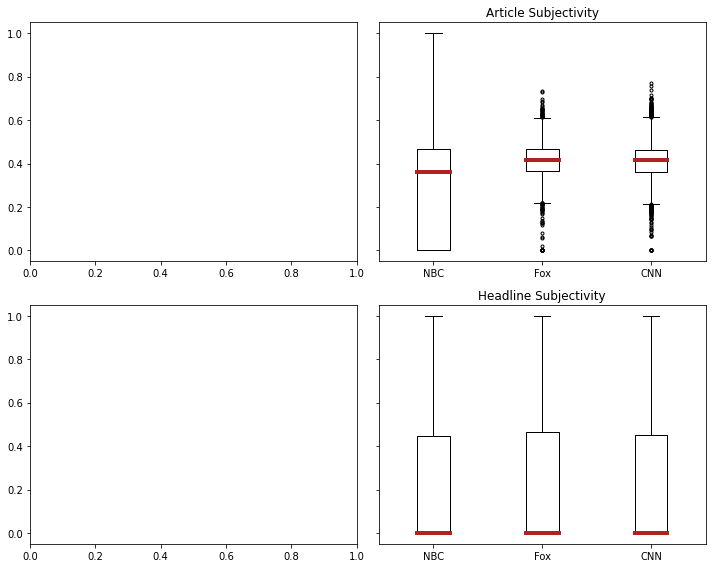

In [ ]:
# https://matplotlib.org/3.1.0/gallery/statistics/boxplot.html

news = ['NBC', 'Fox', 'CNN']

article_polarity  = [nbc_2018['article_blob_polarity'], fox_2018['article_blob_polarity'], cnn_2018['article_blob_polarity']]
article_subjectivity  = [nbc_2018['article_blob_subjectivity'], fox_2018['article_blob_subjectivity'], cnn_2018['article_blob_subjectivity']]
headline_subjectivity  = [nbc_2018['headline_blob_subjectivity'], fox_2018['headline_blob_subjectivity'], cnn_2018['headline_blob_subjectivity']]
headline_polarity  = [nbc_2018['headline_blob_polarity'], fox_2018['headline_blob_polarity'], cnn_2018['headline_blob_polarity']]

if display_images:

  medianprops = dict(linestyle='-', linewidth=4, color='firebrick')

  fig, ax = plt.subplots(2, 2, figsize = (10,8), tight_layout=True, sharey=True)

  ax[0][0].set_title('Article Polarity')
  ax[0][0].boxplot(article_polarity, medianprops=medianprops, sym='.', labels = news)

  ax[0][1].set_title('Article Subjectivity')
  ax[0][1].boxplot(article_subjectivity, medianprops=medianprops, sym='.', labels = news)

  ax[1][0].set_title('Headline Polarity')
  ax[1][0].boxplot(headline_polarity, medianprops=medianprops, sym='.', labels = news)

  ax[1][1].set_title('Headline Subjectivity')
  ax[1][1].boxplot(headline_subjectivity, medianprops=medianprops, sym='.', labels = news)

  plt.show()

Look at how many give opposite evaluations. Positive - Negative. What is being classified differently. How do each of these algorithms differ. Under the hood.

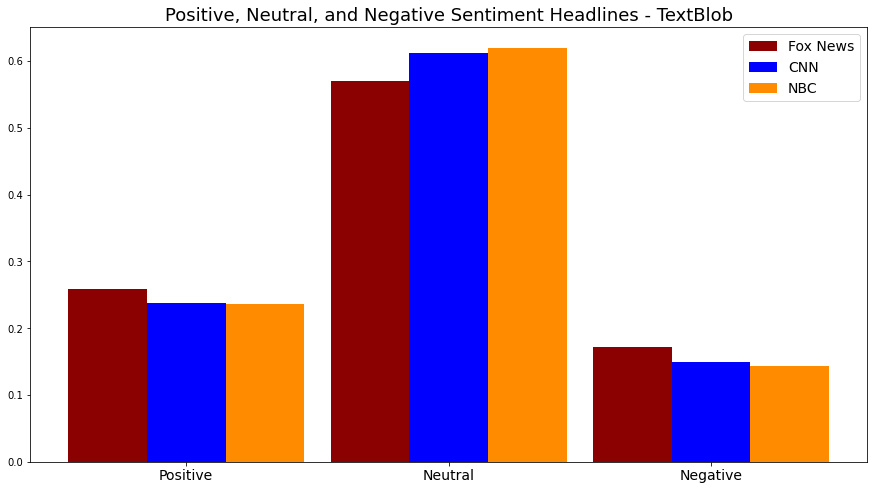

In [ ]:
fox_blob_headline_counts = get_sentiment_counts(fox_2018.headline_blob_polarity_class)
nbc_blob_headline_counts = get_sentiment_counts(nbc_2018.headline_blob_polarity_class)
cnn_blob_headline_counts = get_sentiment_counts(cnn_2018.headline_blob_polarity_class)

fox_blob_article_counts = get_sentiment_counts(fox_2018.article_blob_polarity_class)
nbc_blob_article_counts = get_sentiment_counts(nbc_2018.article_blob_polarity_class)
cnn_blob_article_counts = get_sentiment_counts(cnn_2018.article_blob_polarity_class)


if display_images:

  width = 0.3
  N = 3
  ind = np.arange(N)

  plt.figure(figsize = (15,8))
  plt.bar(ind, [counts / len(fox_2018) for counts in fox_blob_headline_counts], width = .3, label = "Fox News", color = 'darkred')
  plt.bar(ind + width, [counts / len(cnn_2018) for counts in cnn_blob_headline_counts], width = .3, label = "CNN", color = 'blue')
  plt.bar(ind + width + width, [counts / len(nbc_2018) for counts in nbc_blob_headline_counts], width = .3, label = 'NBC', color = 'darkorange')
  plt.xticks(ind + 2*width / 2, ('Positive', 'Neutral', 'Negative'), fontsize = 14)
  plt.title("Positive, Neutral, and Negative Sentiment Headlines - TextBlob", fontsize = 18)
  plt.legend(loc='best', fontsize = 14)
  plt.show()

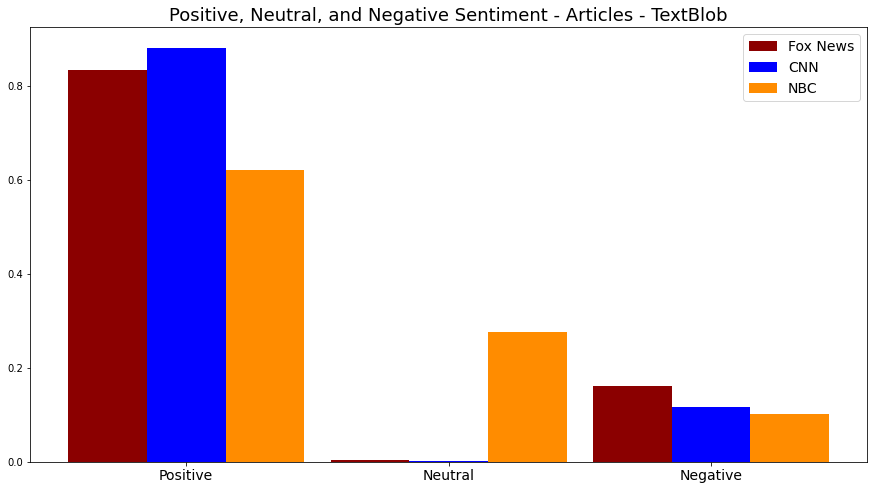

In [ ]:
if display_images:

  width = 0.3
  N = 3
  ind = np.arange(N)

  plt.figure(figsize = (15,8))
  plt.bar(ind, [counts / len(fox_2018) for counts in fox_blob_article_counts], width = .3, label = "Fox News", color = 'darkred')
  plt.bar(ind + width, [counts / len(cnn_2018) for counts in cnn_blob_article_counts], width = .3, label = "CNN", color = 'blue')
  plt.bar(ind + width + width, [counts / len(nbc_2018) for counts in nbc_blob_article_counts], width = .3, label = 'NBC', color = 'darkorange')
  plt.xticks(ind + 2*width / 2, ('Positive', 'Neutral', 'Negative'), fontsize = 14)
  plt.title("Positive, Neutral, and Negative Sentiment - Articles - TextBlob", fontsize = 18)
  plt.legend(loc='best', fontsize = 14)
  plt.show()

## Comparing Textblob and Vader

In [ ]:
print("Number of articles from NBC: ", len(nbc_2018))

print("Matching article classifications from VADER and TextBlob: ", np.count_nonzero(nbc_2018['article_blob_polarity_class'] == nbc_2018['article_vader']))
print("Matching headline classifications from VADER and TextBlob: ", np.count_nonzero(nbc_2018['headline_blob_polarity_class'] == nbc_2018['headline_vader']))


print("\nNumber of articles from Fox: ", len(fox_2018))

print("Matching article classifications from VADER and TextBlob: ", np.count_nonzero(fox_2018['article_blob_polarity_class'] == fox_2018['article_vader']))
print("Matching headline classifications from VADER and TextBlob: ", np.count_nonzero(fox_2018['headline_blob_polarity_class'] == fox_2018['headline_vader']))

print("\nNumber of articles from CNN: ", len(cnn_2018))

print("Matching article classifications from VADER and TextBlob: ", np.count_nonzero(cnn_2018['article_blob_polarity_class'] == cnn_2018['article_vader']))
print("Matching headline classifications from VADER and TextBlob: ", np.count_nonzero(cnn_2018['headline_blob_polarity_class'] == cnn_2018['headline_vader']))


Number of articles from NBC:  9030
Matching article classifications from VADER and TextBlob:  4696
Matching headline classifications from VADER and TextBlob:  4482

Number of articles from Fox:  3106
Matching article classifications from VADER and TextBlob:  1941
Matching headline classifications from VADER and TextBlob:  1344

Number of articles from CNN:  8202
Matching article classifications from VADER and TextBlob:  5409
Matching headline classifications from VADER and TextBlob:  3956


In [ ]:
# fox_2018.to_excel("USML_Project/Data/jake/fox_full_sample.xlsx")
# cnn_2018.to_excel("USML_Project/Data/jake/cnn_full_sample.xlsx")
# nbc_2018.to_excel("USML_Project/Data/jake/nbc_full_sample.xlsx")